# Overview of the data set

The dataset is from the  [uci machine learning repository](https://archive.ics.uci.edu/ml/datasets/Heart+Disease). Here is a description of every variable taken from the uci repository:

`cp`: chest pain type:
1. typical angina
2. atypical angina
3. non-anginal pain
4. asymptomatic 

`trestbps`: resting blood pressure (in mm Hg on admission to the hospital)

`fbs`: fasting blood sugar > 120 mg/dl: 1 = true and 0 = false

`restecg`: resting electrocardiographic results
0. normal
1. having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV)
2. showing probable or definite left ventricular hypertrophy by Estes' criteria

`thalach`: maximum heart rate achieved

`exang`: exercise induced angina: 1 = yes and 0 = no

`oldpeak`: ST depression induced by exercise relative to rest

`slope`: the slope of the peak exercise ST segment
1. upsloping
2. flat
3. downsloping 

`ca`: number of major vessels (0-3) colored by flourosopy 

`thal`:  3 = normal; 6 = fixed defect; 7 = reversable defect

`age`: age in years

`chol`: serum cholestoral in mg/dl

`sex`: 1 = male and 0 = female

`target`: 1 = disease; 0 = no disease

I saved a copy of the data in the `data.csv` file.

In [1]:
library(tidyverse)
df <- read_csv("data.csv")

Warning message:
"package 'tidyverse' was built under R version 3.6.1"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
-- Attaching packages --------------------------------------- tidyverse 1.2.1 --
v ggplot2 3.1.1       v purrr   0.3.2  
v tibble  2.1.1       v dplyr   0.8.0.1
v tidyr   0.8.3       v stringr 1.4.0  
v readr   1.3.1       v forcats 0.4.0  
-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()
Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)


As one can see in the ouput of the `read_csv` function, every variable is from the type _double_. I will transfrom the variables corresponding to the description: 

In [2]:
df  <- df %>%
    transmute(age,
              thalach,
              trestbps,
              oldpeak,
              ca,
              chol,
              restecg = factor(df$restecg, levels = c(0,1,2), labels = c("normal", "ST-T_abnormalty", "hypertrophy")),
              fbs = factor(df$fbs, levels = c(0,1), labels = c("no", "yes")),
              sex = factor(df$sex, levels = c(0,1), labels = c("Female", "Male")),
              exang = factor(df$exang, levels = c(0,1), labels = c("no", "yes")),
              cp = factor(df$cp, levels = c(0,1,2,3), labels = c("typical_angina", "atypical_angina","non-anginal_pain", "asymptomatic")),
              slope = factor(df$slope, levels = c(0,1,2), labels = c("upsloping", "flat", "downsloping")),              
              target = factor(df$target, levels = c(0,1), labels = c("no_disease", "disease")),
              thal = factor(df$thal,levels = c(0,1,2,3), labels = c("normal", "fixed_defect", "reversable_defect", "?"))
              )
   

I checked the output and recognized that `thal` has four instead of three levels:

In [3]:
unique(df$thal)

[1] fixed_defect      reversable_defect ?                 normal           
Levels: normal fixed_defect reversable_defect ?

That is the reason I coded the `thal` variable with four levels. I will investiage this problem later. There are also no NA's int the data set and it consists of 303 unique observations: 

In [4]:
nrow(df)
nrow(df) == nrow(drop_na(df))

[1] 303

[1] TRUE

Now let's check the distribution of the target:


no_disease    disease 
       138        165 

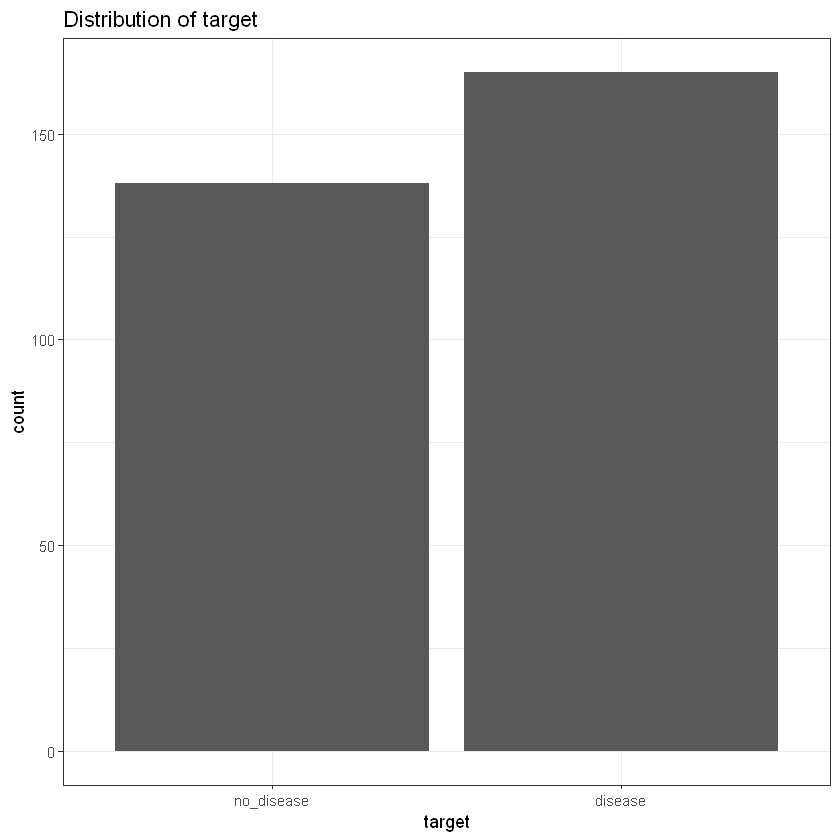

In [5]:
table(df$target)

ggplot(df, aes(x = target)) + 
geom_bar() + 
theme_bw() + 
labs(title = "Distribution of target") 

I would say that the data set is well balanced with respect to the target. This the last time I used the whole data set. I will use 80 % as the training set and 20 % as the test set. Optimization will be done with the training set and at the and of the analysis we will see the performance on the test set. This will be the only time that I will use the test set, hence the analysis is then over.

In [6]:
library(caret)  
inTraining <- createDataPartition(df$target, p = 0.8, list = FALSE)
df_train <- df[ inTraining,]
df_test  <- df[-inTraining,]

table(df_train$target)
nrow(df_train)
nrow(df_test)

Warning message:
"package 'caret' was built under R version 3.6.1"Loading required package: lattice

Attaching package: 'caret'

The following object is masked from 'package:purrr':

    lift




no_disease    disease 
       111        132 

[1] 243

[1] 60

I wrote two functions for this task:  

In [7]:
get_df <- function(df){
  result <- df %>%
    transmute(age,
              thalach,
              trestbps,
              oldpeak,
              ca,
              chol,
              restecg = factor(df$restecg, levels = c(0,1,2), labels = c("normal", "ST-T_abnormalty", "hypertrophy")),
              fbs = factor(df$fbs, levels = c(0,1), labels = c("no", "yes")),
              sex = factor(df$sex, levels = c(0,1), labels = c("Female", "Male")),
              exang = factor(df$exang, levels = c(0,1), labels = c("no", "yes")),
              cp = factor(df$cp, levels = c(0,1,2,3), labels = c("typical_angina", "atypical_angina","non-anginal_pain", "asymptomatic")),
              slope = factor(df$slope, levels = c(0,1,2), labels = c("upsloping", "flat", "downsloping")),              
              target = factor(df$target, levels = c(0,1), labels = c("no_disease", "disease")),
              thal = factor(df$thal,levels = c(0,1,2,3), labels = c("normal", "fixed_defect", "reversable_defect", "?"))
    )
}

get_training_df <- function(p = 0.8) {
  set.seed(25)
  df_raw <- read_csv("data.csv")
  df <- get_df(df_raw)
  inTraining <- createDataPartition(dft$target, p = p, list = FALSE)
  training <- df[ inTraining,]
  # testing  <- df[-inTraining,]
  return(training)
}



These functions are in the `helpers.r` script. I will source this script at the begin of every other notebook and call the `get_training_df` function to receive the training set:

In [8]:
source("helpers.r")
df <- get_training_df()

Parsed with column specification:
cols(
  age = col_double(),
  sex = col_double(),
  cp = col_double(),
  trestbps = col_double(),
  chol = col_double(),
  fbs = col_double(),
  restecg = col_double(),
  thalach = col_double(),
  exang = col_double(),
  oldpeak = col_double(),
  slope = col_double(),
  ca = col_double(),
  thal = col_double(),
  target = col_double()
)
